In [1]:
import torch
from IPython import display
from d2l import torch as d2l


In [2]:
batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

100%|██████████| 26421880/26421880 [00:31<00:00, 834182.14it/s] 


Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 152237.96it/s]


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:07<00:00, 603701.22it/s]


Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 4448347.13it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



In [20]:
num_inputs = 784
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)
W, b

(tensor([[-0.0144,  0.0147,  0.0013,  ...,  0.0044, -0.0057, -0.0057],
         [ 0.0280, -0.0009, -0.0040,  ...,  0.0096,  0.0013, -0.0116],
         [-0.0053,  0.0180,  0.0015,  ..., -0.0091, -0.0085,  0.0171],
         ...,
         [ 0.0012, -0.0096, -0.0007,  ..., -0.0177, -0.0088,  0.0109],
         [ 0.0014,  0.0068, -0.0006,  ..., -0.0100, -0.0151, -0.0156],
         [-0.0118,  0.0198, -0.0021,  ..., -0.0046,  0.0119, -0.0119]],
        requires_grad=True),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True))

In [4]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True)
X.sum(1, keepdim=True)

tensor([[ 6.],
        [15.]])

In [10]:
# 实现softmax
def softmax(X):
    X_exp = torch.exp(X)
    # print(f'X_exp: {X_exp}')
    partition = X_exp.sum(1, keepdim=True)
    # print(f'partition: {partition}')
    return X_exp / partition

In [11]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

X_exp: tensor([[0.2629, 1.6192, 1.2477, 0.5677, 3.9920],
        [0.7934, 0.7116, 9.3629, 1.3264, 3.8046]])
partition: tensor([[ 7.6894],
        [15.9989]])


(tensor([[-1.3361,  0.4819,  0.2213, -0.5662,  1.3843],
         [-0.2314, -0.3403,  2.2368,  0.2825,  1.3362]]),
 tensor([[0.0342, 0.2106, 0.1623, 0.0738, 0.5192],
         [0.0496, 0.0445, 0.5852, 0.0829, 0.2378]]),
 tensor([1.0000, 1.0000]))

In [19]:
# 实现softmax回归模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [22]:
# 创建一个数据y_hat，其中包含2个样本在3个类别的预测概率， 使用y作为y_hat中概率的索引
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]


tensor([0.1000, 0.5000])

In [24]:
# 实现交叉熵损失函数
# 交叉熵是信息论中的一个重要概念，它的大小表示两个概率分布之间的差异，可以通过最小化交叉熵来得到目标概率分布的近似分布。
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

## 分类任务的损失函数的选择
https://zhuanlan.zhihu.com/p/124309304
https://www.zhihu.com/tardis/zm/art/35709485?source_id=1005
* 分类错误率
最解决的损失函数
错误率= 分类错误数量 / 所有样本数量
对于错误率相同的两个模型，不能反映哪一个模型会比较好

* 均方误差 MSE
误差平方的均值
可以判断出两个模型的好坏
但是在分类任务中，使用sigmoid/softmax得到的概率，配合MSE损失函数时，采用梯度下降进行学习的时候，会出现一些模型一开始训练时，学习速率非常慢的情况，即
在输出概率值接近0或者1的时候，偏导数非常小，会造成模型刚开始训练的时候，偏导数几乎消失

* 交叉熵
损失函数是一个凸函数，求导时可以得到全局最优值
几乎都和sigmoid/softmax函数一起出现

In [27]:
# 将预测类别与真实y元素进行比较，计算准确率的函数，在评估分类模型的性能时
def accuracy(y_hat, y):
    # 如果y_hat是二维的，并且有多于一个的列（即，模型输出是每个类别的得分或概率
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        # 使用argmax找到每行得分最高的索引，这些索引代表预测的类别
        # argmax 是一个在多个科学计算库中常见的函数，它用来找出给定数组或张量（tensor）中最大值的位置（索引）
        y_hat = y_hat.argmax(axis=1)
    # 将预测结果转换为真实标签的数据类型，然后进行比较
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())
accuracy(y_hat, y) / len(y)

0.5

In [28]:
# 在`n`个变量上累加
class Accumulator:
    def __init__(self, n):
        self.data = [0.0]*n
    def add(self, *args):
        self.data = [a+float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0]*len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [32]:
# 评估在任意模型上的准确率
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        # This sets the network in evaluation mode. 
        # This is necessary because some layers like dropout layers and batch normalization layers 
        # behave differently during training than during model evaluation.
        net.eval()
    metric = Accumulator(2)
    for X, y in data_iter:
        # y.numel() returns the total number of elements in y
        # which is the number of labels (this should be the batch size unless it’s the last batch, which can be smaller).
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

evaluate_accuracy(net, test_iter)

X_exp: tensor([[0.9624, 1.0945, 0.8999,  ..., 1.0426, 1.0783, 0.9731],
        [1.2609, 1.1594, 0.8973,  ..., 1.1008, 1.2974, 0.9295],
        [1.2117, 1.0091, 0.7426,  ..., 1.0244, 1.1603, 0.8312],
        ...,
        [0.9648, 1.0199, 1.0008,  ..., 1.0768, 1.0529, 0.9816],
        [0.9711, 1.0587, 0.8621,  ..., 0.9959, 1.1079, 0.9753],
        [1.3013, 1.2412, 0.8865,  ..., 1.1175, 1.2182, 0.9111]],
       grad_fn=<ExpBackward0>)
partition: tensor([[10.2946],
        [10.5764],
        [10.2370],
        [10.2433],
        [10.4274],
        [10.2284],
        [10.0583],
        [10.0704],
        [10.0030],
        [10.1539],
        [10.7300],
        [10.3261],
        [10.4524],
        [10.0146],
        [10.5081],
        [10.0902],
        [10.1642],
        [10.3896],
        [10.3865],
        [10.0639],
        [ 9.9821],
        [10.0713],
        [10.6467],
        [10.2996],
        [10.0163],
        [10.1887],
        [10.7728],
        [10.3512],
        [10.2323],
  

0.1296

In [33]:
# Softmax回归的训练
def train_epoch_ch3(net, train_iter, loss, updater):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            updater.step()
            metric.add(float(l)*len(y), accuracy(y_hat, y), y.size.numel())
        else:
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]


In [34]:
# 定义一个在动画中绘制数据的类
class Animator:  
    """在动画中绘制数据。"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        self.config_axes = lambda: d2l.set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [40]:
# 训练函数
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics= train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [38]:
lr = 0.1
def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)


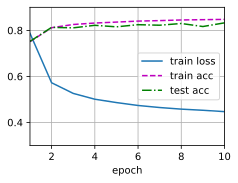

In [41]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

X_exp: tensor([[1.1862e-02, 1.1448e-02, 8.4334e-02,  ..., 2.3362e+02, 1.0169e+01,
         6.3796e+02],
        [7.1402e+00, 1.4943e-01, 1.5610e+04,  ..., 5.3351e-05, 1.4637e+00,
         2.0924e-03],
        [2.0177e+01, 3.6199e+05, 4.3190e+00,  ..., 1.0020e-01, 2.2716e-01,
         3.1799e-03],
        ...,
        [6.4593e-02, 1.9281e-01, 3.1247e-01,  ..., 1.0322e+01, 5.5177e-01,
         3.4156e+00],
        [1.9841e-01, 2.5027e-02, 2.2710e-01,  ..., 5.0918e+00, 3.1573e+01,
         9.2766e+00],
        [1.4728e+00, 2.0511e+00, 2.3864e+03,  ..., 1.0845e-04, 2.9644e+00,
         2.5101e-04]], grad_fn=<ExpBackward0>)
partition: tensor([[1.0069e+03],
        [1.6622e+04],
        [3.6207e+05],
        [1.2051e+05],
        [1.1599e+02],
        [9.3359e+03],
        [6.0112e+02],
        [2.1942e+02],
        [2.4023e+01],
        [1.0608e+03],
        [7.6832e+02],
        [1.5134e+02],
        [1.9910e+02],
        [2.5023e+03],
        [8.6182e+03],
        [5.0354e+03],
        [1

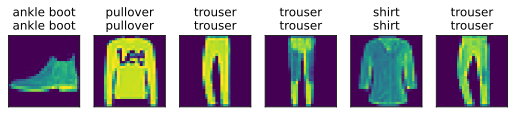

In [42]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签（定义见第3章）。"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)